# Cloud and shadow masking

Following the method proposed in "Cloud/shadow detection based on spectral indices for multi/hyperspectral optical remote sensing imagery" (Zhai et al. 2018)

NOTE: I have not yet included a spatial matching code block.  That's because I want the dark areas and water to be masked out, which is what the spatial matching aims to prevent.  Feel free to add this.  I might add it later as an option.

Input is as explained in the second block.

The mask is shown before the image is actually masked.  This allows you to adjust the parameters to optimize the mask.

In [1]:
import os
import rasterio
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from scipy import ndimage

In [ ]:
# Directory path for folder with image
folder = 'path_to_folder'

# Input image as a .tif file
input_image = 'your_image.tif'

# Set to 'True' for four-band images; 'False' if image has swir1 and swir2 bands
four_band = True

# Enter the band numbers
blue_band = 1
green_band = 2
red_band = 3
nir_band = 4
swir1_band = 6
swir2_band = 7

# Adjust these as needed

# Parameters for cloud mask:
T1 = 1 # Genearlly set small (e.g.,1); select from [0.01, 0.1, 1, 10, 100]
t2 = 1/10 # Adjusting coefficient. Generally selected from [1/10, 1/9, 1/8, 1/7, 1/6, 1/5, 1/4, 1/3, 1/2]

# Parameters for shadow mask:
t3 = 2/3 # Adjusting coefficient. Generally selected from [1/4, 1/3, 1/2, 2/3, 3/4]
t4 = 2/3 # Adjusting coefficient. Generally selected from [1/2, 2/3, 3/4, 4/5, 5/6] 

T7 = 9 #Kernel size for cloud median filter
T8 = 3 #Kernel size for shadow median filter

In [2]:
def calc_ci1_4band (blue, green, red, nir):
    # CI 1 equation with 4 bands = (3 * nir) / (blue+green+red)'
    ci1 = (red*nir) / (blue+green+red)
    return ci1
    
def calc_ci1 (blue, green, red, nir, swir1):
    # CI 1 equation with SWIR bands = (nir + (2*swir1)) / (blue+green+red)
    ci1 = (nir + (2*swir1)) / (blue+green+red)
    return ci1

def calc_ci2_4band (blue, green, red, nir):
    # CI2 equation with 4 bands = (blue+green+red+nir)/4
    ci2 = (blue+green+red+nir)/4
    return ci2
    
def calc_ci2 (blue, green, red, nir, swir1, swir2):
    # CI2 equation with SWIR bands = (blue+green+red+nir+swir1+swir2) / 6
    ci2 = (blue+green+red+nir+swir1+swir2) / 6
    return ci2

def calc_csi (nir, swir1):
    # CSI equation with SWIR bands = (nir+swir1) / 2 
    csi = (nir+swir1)/2
    return csi

In [38]:
os.chdir('..')

# Get band data
image_object = rasterio.open(input_image)

blue = image_object.read(blue_band)
green = image_object.read(green_band)
red = image_object.read(red_band)
nir = image_object.read(nir_band)

if four_band == False:
    swir1 = image_object.read(swir1_band)
    swir2 = image_object.read(swir2_band)

/home/sarahwegmueller/anaconda3/envs/Image_prep/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sarahwegmueller/anaconda3/envs/Image_prep/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]


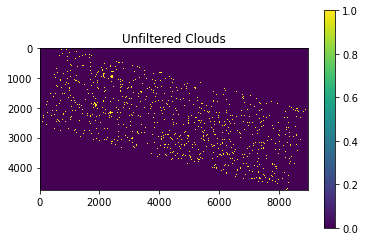

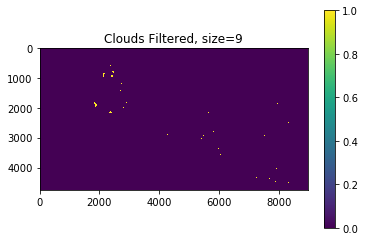

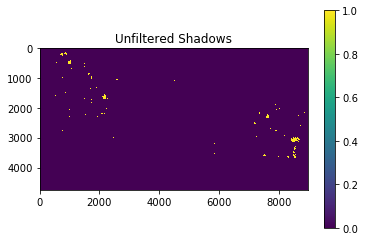

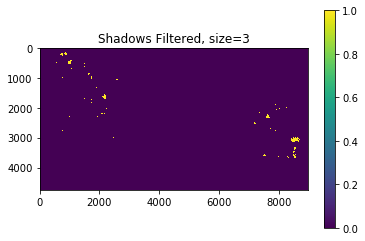

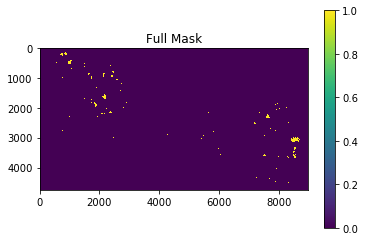

In [39]:
if four_band == True:   
    ci1 = calc_ci1_4band(blue, green, red, nir)
    ci2 = calc_ci2_4band(blue, green, red, nir)
    
else:
    ci1 = calc_ci1(blue, green, red, nir, swir1)
    ci2 = calc_ci2(blue, green, red, nir, swir1, swir2)
    
ci2_for_calc = ci2[ci2 != 0]

T2 = np.mean(ci2_for_calc) + (t2 * (np.max(ci2_for_calc) - np.mean(ci2_for_calc)))

clouds = (np.abs(ci1) < T1) | (np.abs(ci2) > T2)

plt.imshow(clouds, vmin=np.min(clouds), vmax=np.max(clouds))
plt.title('Unfiltered Clouds')
plt.colorbar()
plt.show()

# Apply median filter
cloud_med = ndimage.median_filter(clouds, T7)
plt.imshow(cloud_med, vmin=np.min(cloud_med), vmax=np.max(cloud_med))
plt.title('Clouds Filtered, size='+ str(T7))
plt.colorbar()
plt.show()

### Shadows ###
# for 4-band imagery (no swir), csi = nir band

if four_band == True:
    csi = nir
else:
    csi = calc_csi(nir, swir1)
    
csi_for_calc = csi[csi != 0]

blue_data_for_calc = blue[blue != 0]

T3 = np.min(csi_for_calc) + (t3 * (np.mean(csi_for_calc) - np.min(csi_for_calc)))
T4 = np.min(blue_data_for_calc) + (t4*(np.mean(blue_data_for_calc) - np.min(blue_data_for_calc)))
shadows = (csi < T3) & (blue < T4) & (blue != 0)
plt.imshow(shadows, vmin=np.min(shadows), vmax=np.max(shadows))
plt.title('Unfiltered Shadows')
plt.colorbar()
plt.show()

#Spatial matching
# not implemented 

# Apply median filter
shd_med = ndimage.median_filter(shadows, T8)
plt.imshow(shd_med, vmin=np.min(shd_med), vmax=np.max(shd_med))
plt.title('Shadows Filtered, size='+ str(T8))
plt.colorbar()
plt.show()

# Combine masks and write to file
cloud_int = cloud_med.astype('uint8') 
shd_int = shd_med.astype('uint8')

mask = (cloud_int==1)|(shd_int==1)
mask = mask.astype('uint16')

plt.imshow(mask, vmin=np.min(mask), vmax=np.max(mask))
plt.title('Full Mask')
plt.colorbar()
plt.show()

# Read metadata of first file
meta = image_object.profile
# Update meta to reflect the number of layers
meta['count'] = 1
meta['nodata'] = 0
meta['tiled'] = True

mask_fp = input_image[:-4]+'_mask.tif'

with rasterio.open(mask_fp, 'w', **meta) as dst:
    dst.write(mask, 1)

In [29]:
# Mask image and write to tif

mask_bool = mask == 1 # Convert the mask back to bool
profile = image_object.profile
masked_image = input_image[:-4]+'_cld_shd_masked.tif' 

for num, band in enumerate(range(1, image_object.count+1)):
    print('Masking and writing band ', num+1)
    data = image_object.read(band)
    tmp = ma.masked_array(data, mask_bool)
    arr = np.zeros((np.shape(data)[0], np.shape(data)[1]), dtype=np.uint16)
    arr = ma.filled(tmp, 0)

    if num == 0:
        with rasterio.open(masked_image, 'w', **profile) as dst:
            dst.write(arr, num+1)
    else:
        with rasterio.open(masked_image, 'r+', **profile) as dst:
            dst.write(arr, num+1)

Masking and writing band  1
Masking and writing band  2
Masking and writing band  3
Masking and writing band  4
Masking and writing band  5
Masking and writing band  6
Masking and writing band  7
